# Présentation 2 Septembre 2022

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import guitarsounds
from guitarsounds import Sound
import sys, os
import inspect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import librosa
import librosa.display
import DEV_utils as du
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d, InterpolatedUnivariateSpline
import scipy.signal

## Soundfile loading and function definitions

In [3]:
wood_sounds = du.load_wood_sounds()
carbon_sounds = du.load_carbon_sounds()
nylon_sounds = du.load_nylon_sounds()
all_sounds = wood_sounds + carbon_sounds + nylon_sounds
notes = du.get_notes_names()
wood_sounds = du.arr2notedict(wood_sounds)
carbon_sounds = du.arr2notedict(carbon_sounds)
nylon_sounds = du.arr2notedict(nylon_sounds)

In [4]:
def zero_crossing_fund(s):
    """ 
    Estimate the signal fundamental from the zero crossing rate
    """
    # Create a spline interpolation of the signal
    spl = InterpolatedUnivariateSpline(s.signal.time(), s.signal.signal)
    # Fin the roots (zero crossings)
    spl_roots = spl.roots()
    # Find the fundamental frequency from the zero crossing rate
    freqs = []
    for i in range(2, 6):
        # Compute the periods from the root
        intervs = spl_roots[i::i] - spl_roots[0:-i:i]
        # F = 1/T
        freq = 1/(intervs)
        # Fundamental is always < 350
        freq = freq[freq<350]
        # Store
        freqs.append(freq)
    hist_data = []
    for fr, i in zip(freqs, range(2,6)):
        dt = np.histogram(fr, 200)
        hist_data.append(dt)
    best_range = np.argmax([np.max(hd[0]) for hd in hist_data])
    best_range = np.argsort([np.max(hd[0]) for hd in hist_data])[-1]
    stat_fund = hist_data[best_range][1][np.argmax(hist_data[best_range][0])]
    return stat_fund
        
def interpolate_sig(s):
    """
    Return a Interpolated spline class instance of the signal
    """
    # Create a spline interpolation of the signal
    spl = InterpolatedUnivariateSpline(s.signal.time(), s.signal.normalize().signal)
    return spl


def zero_crossing(s):
    """
    Return all the zero crossings of the signal
    """
    spl = interpolate_sig(s)
    # Fin the roots (zero crossings)
    return spl.roots()


def signal_onset_idx(s, onset_thresh=0.05):
    """
    Return the idx of the signal onset threshold
    """
    try:
        # Where the signal first cross 0.05
        onset_idx = np.where(s.signal.normalize().signal>onset_thresh)[0][0] 
        return onset_idx
    
    except IndexError:
        raise Error('No onset could be found')
    

def period_crossings(s, fund, max_time=1):
    """
    Return the signal zero crossing corresponding to its fundamental period
    """
    onset_idx = signal_onset_idx(s)
    roots = zero_crossing(s)
    t = roots[roots<s.signal.time()[onset_idx]][-1]
    fund_period = 1/fund
    period_cross = [t]
    # Find all the period spaced zero crossings
    while t < max_time:
        idx = np.argmin(np.abs(roots - (t+fund_period)))
        t = roots[idx]
        period_cross.append(t)
    return period_cross


def period_decomp(s, fund, max_time=1, subsig_size=200):
    """
    Convert the period zero crossings to sub signals
    """
    crossings = period_crossings(s, fund, max_time=max_time)
    sig_itrp = interpolate_sig(s)
    sub_sigs = []
    sub_times = []
    for i, cr in enumerate(crossings[:-1]):
        time = np.linspace(cr, crossings[i+1], subsig_size)
        sig = sig_itrp(time)
        sub_sigs.append(sig)
        sub_times.append(time)
    return sub_times, sub_sigs

def spec_freq(sr=22050):
    return librosa.fft_frequencies(sr=sr)

def spec_time(spec, hop_length=32):
    return librosa.frames_to_time(np.arange(spec.shape[1]), hop_length=32)

def An_interpolator(time, freq, spec, filtr=0):
    
    kernel = np.array([[1, 1, 1,],
                       [1, 1, 1,],
                       [1, 1, 1,],])

    kernel = kernel/np.sum(kernel)

    nylon_spec_filtr = nylon_spec
    for i in range(filtr):
        nylon_spec_filtr = convolve(nylon_spec_filtr, kernel)

    An_itrp = interp2d(tim, frq, nylon_spec_filtr)
    
    return An_itrp

def sound_arr_from_itrp(itrp, fund):

    # Use theoretical partial data
    sigarr=0
    # Time at sample rate intervals
    time=np.linspace(tim[0], tim[-1], 22050*2)

    while fund < 10000:
        sigarr += itrp(time, fund) * np.sin(fund * time * 2 * np.pi)
        fund += 110

    sigarr *= 0.95 / np.max(np.abs(sigarr))
    
    # Apply onset envelop
    env = du.get_expenv(-1)
    # Apply it to time = 0.0 - 0.1 s
    t_idx = np.arange(time.shape[0])[time < 0.1][-1]
    sigarr[:t_idx] = env(t[:t_idx]) * sigarr[:t_idx]
    # Fade out the last 20 samples
    sigarr[-20:] = sigarr[-20:] * np.linspace(1, 0.1, 20)
    return sigarr

# Signal period decomposition for sound generation

## 1. Signal fundamental period decompositon

### 1.1 Zero crossing detection and distribution

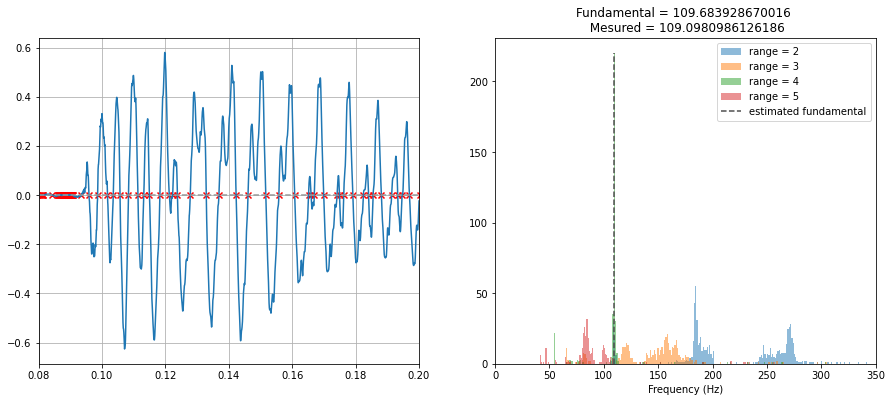

In [5]:
# Choose a signal
st = all_sounds[0]

# Plot the time signal
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax.plot(st.signal.time(), st.signal.signal)
ax.plot([st.signal.time()[0], st.signal.time()[-1]], [0, 0], color='0.6', linestyle='--')
ax.set_xlim(0.08, 0.2)
ax.grid('on', which='major')
ax.grid('on', which='minor')

# Find the signal start at 0 crossing
spl = InterpolatedUnivariateSpline(st.signal.time(), st.signal.signal)
#plt.plot(st.signal.time(), spl(st.signal.time()))
spl_roots = spl.roots()
ax.scatter(spl_roots, np.zeros_like(spl_roots), marker='x', color='red')

# Find the fundamental frequency from the zero crossing rate
freqs = []
for i in range(2, 6):
    intervs = spl_roots[i::i] - spl_roots[0:-i:i]
    freq = 1/(intervs)
    freq = freq[freq<350]
    freqs.append(freq)
hist_data = []
for fr, i in zip(freqs, range(2,6)):
    dt = ax2.hist(fr, 200, alpha=0.5, label=f'range = {i}')
    hist_data.append(dt)
    
best_range = np.argmax([np.max(hd[0]) for hd in hist_data])
best_range = np.argsort([np.max(hd[0]) for hd in hist_data])[-1]
stat_fund = hist_data[best_range][1][np.argmax(hist_data[best_range][0])]
    
ax2.plot((st.fundamental, st.fundamental), (0, np.max([np.max(hd[0]) for hd in hist_data])), 
         color='0.3', linestyle='--', label='estimated fundamental')
ax2.set_xlim(0, 350)
ax2.legend()
ax2.set_title(f'Fundamental = {st.fundamental} \n Mesured = {stat_fund}')
ax2.set_xlabel('Frequency (Hz)')
plt.show()

- Signal zero crossing could be used to infer the fundamental of the signal

### 1.2 Sub period detection and decomposition

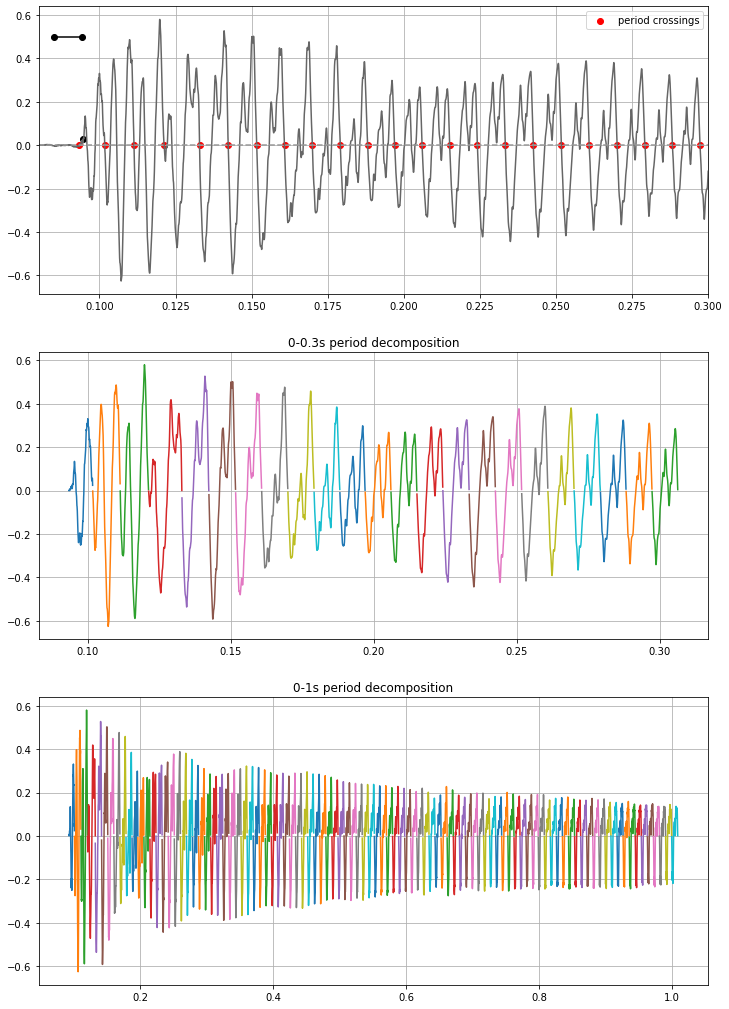

In [6]:
# Plot the time signal
fig, axs = plt.subplots(3, 1, figsize=(12,18))

# GET THE FIRST AXIS
ax = axs[0]
ax.plot(st.signal.time(), st.signal.signal, color='0.4')
ax.plot([st.signal.time()[0], st.signal.time()[-1]], [0, 0], color='0.6', linestyle='--')
ax.set_xlim(0.08, 0.3)
ax.grid('on', which='major')
ax.grid('on', which='minor')
ost = st.signal.find_onset()
# Find the signal start at 0 crossing
spl = InterpolatedUnivariateSpline(st.signal.time(), st.signal.signal)
spl_roots = spl.roots()

# Find the signal onset with a threshold
onset_thresh = 0.05
onset_idx = np.where(st.signal.signal>0.03)[0][0]
ax.scatter(st.signal.time()[onset_idx], st.signal.signal[onset_idx], color='k', marker='o')
# find the closest zero crossing
t = spl_roots[spl_roots<st.signal.time()[onset_idx]][-1]
ax.scatter(t, 0, marker='o', color='r', label='period crossings')
m_period = 1/stat_fund
period_cross = [t]

# Plot all the zero crossings
while t < 0.3:
    idx = np.argmin(np.abs(spl_roots - (t+m_period)))
    t = spl_roots[idx]
    period_cross.append(t)
    #t = spl_roots[spl_roots<(t+m_period)][-1]
    ax.scatter(t, 0, marker='o', color='r')

ax.scatter([0.085, 0.085+m_period], [0.5, 0.5], color='k')
ax.plot([0.085, 0.085+m_period], [0.5, 0.5], color='k')
ax.legend()

# GET THE SECOND AXIS
ax = axs[1]

for i, ci in enumerate(period_cross[:-1]):
    s = st.signal.signal[np.logical_and(ci<=st.signal.time(), st.signal.time()<=period_cross[i+1])]
    tm = st.signal.time()[np.logical_and(ci<=st.signal.time(), st.signal.time()<=period_cross[i+1])]
    ax.plot(tm, s)
    
ax.set_title('0-0.3s period decomposition')    
ax.grid()


# GET THE THIRD AXIS
ax = axs[2]

while t < 1:
    idx = np.argmin(np.abs(spl_roots - (t+m_period)))
    t = spl_roots[idx]
    period_cross.append(t)
    
for i, ci in enumerate(period_cross[:-1]):
    s = st.signal.signal[np.logical_and(ci<=st.signal.time(), st.signal.time()<=period_cross[i+1])]
    t = st.signal.time()[np.logical_and(ci<=st.signal.time(), st.signal.time()<=period_cross[i+1])]
    ax.plot(t, s)

ax.grid()
ax.set_title('0-1s period decomposition')

plt.show()

## 2. Testing the signal period decomposition

### 2.1 Fundamental considerations in period decomposition

- FFT based fundamental inference

In [7]:
for ky in wood_sounds:
    print(f'Real : {du.note_freq(ky)} Hz,    FFT : {np.around(wood_sounds[ky].fundamental, 2)} Hz')
    print(f'Real : {du.note_freq(ky)} Hz,    FFT : {np.around(carbon_sounds[ky].fundamental, 2)} Hz')
    print(f'Real : {du.note_freq(ky)} Hz,    FFT : {np.around(nylon_sounds[ky].fundamental, 2)} Hz')

Real : 110.0 Hz,    FFT : 109.68 Hz
Real : 110.0 Hz,    FFT : 110.0 Hz
Real : 110.0 Hz,    FFT : 109.87 Hz
Real : 247.0 Hz,    FFT : 100.97 Hz
Real : 247.0 Hz,    FFT : 143.98 Hz
Real : 247.0 Hz,    FFT : 247.78 Hz
Real : 147.0 Hz,    FFT : 145.86 Hz
Real : 147.0 Hz,    FFT : 146.52 Hz
Real : 147.0 Hz,    FFT : 146.58 Hz
Real : 330.0 Hz,    FFT : 328.71 Hz
Real : 330.0 Hz,    FFT : 328.8 Hz
Real : 330.0 Hz,    FFT : 117.95 Hz
Real : 82.01 Hz,    FFT : 82.26 Hz
Real : 82.01 Hz,    FFT : 81.99 Hz
Real : 82.01 Hz,    FFT : 82.78 Hz
Real : 196.0 Hz,    FFT : 100.38 Hz
Real : 196.0 Hz,    FFT : 196.19 Hz
Real : 196.0 Hz,    FFT : 195.5 Hz


- Zero crossing based fundamental inference

In [8]:
for ky in wood_sounds:
    nf = du.note_freq(ky)
    fund = np.around(zero_crossing_fund(wood_sounds[ky]), 2)
    print('Real : {} Hz,    ZCR : {} Hz,     {} diff'.format(nf, fund, np.around(np.abs(fund-nf),2)))
    fund = np.around(zero_crossing_fund(carbon_sounds[ky]), 2)
    print('Real : {} Hz,    ZCR : {} Hz,     {} diff'.format(nf, fund, np.around(np.abs(fund-nf),2)))
    fund = np.around(zero_crossing_fund(nylon_sounds[ky]), 2)
    print('Real : {} Hz,    ZCR : {} Hz,     {} diff'.format(nf, fund, np.around(np.abs(fund-nf),2)))

Real : 110.0 Hz,    ZCR : 109.1 Hz,     0.9 diff
Real : 110.0 Hz,    ZCR : 109.36 Hz,     0.64 diff
Real : 110.0 Hz,    ZCR : 109.84 Hz,     0.16 diff
Real : 247.0 Hz,    ZCR : 122.36 Hz,     124.64 diff
Real : 247.0 Hz,    ZCR : 246.32 Hz,     0.68 diff
Real : 247.0 Hz,    ZCR : 122.56 Hz,     124.44 diff
Real : 147.0 Hz,    ZCR : 145.24 Hz,     1.76 diff
Real : 147.0 Hz,    ZCR : 72.63 Hz,     74.37 diff
Real : 147.0 Hz,    ZCR : 146.44 Hz,     0.56 diff
Real : 330.0 Hz,    ZCR : 163.94 Hz,     166.06 diff
Real : 330.0 Hz,    ZCR : 163.72 Hz,     166.28 diff
Real : 330.0 Hz,    ZCR : 162.66 Hz,     167.34 diff
Real : 82.01 Hz,    ZCR : 81.91 Hz,     0.1 diff
Real : 82.01 Hz,    ZCR : 81.06 Hz,     0.95 diff
Real : 82.01 Hz,    ZCR : 81.41 Hz,     0.6 diff
Real : 196.0 Hz,    ZCR : 97.45 Hz,     98.55 diff
Real : 196.0 Hz,    ZCR : 196.39 Hz,     0.39 diff
Real : 196.0 Hz,    ZCR : 195.6 Hz,     0.4 diff


- The two methods perform differently for different signals
- None is precise enough to be used for period decomposition

### 2.2 Period decomposition for each string of an acoustic guitar

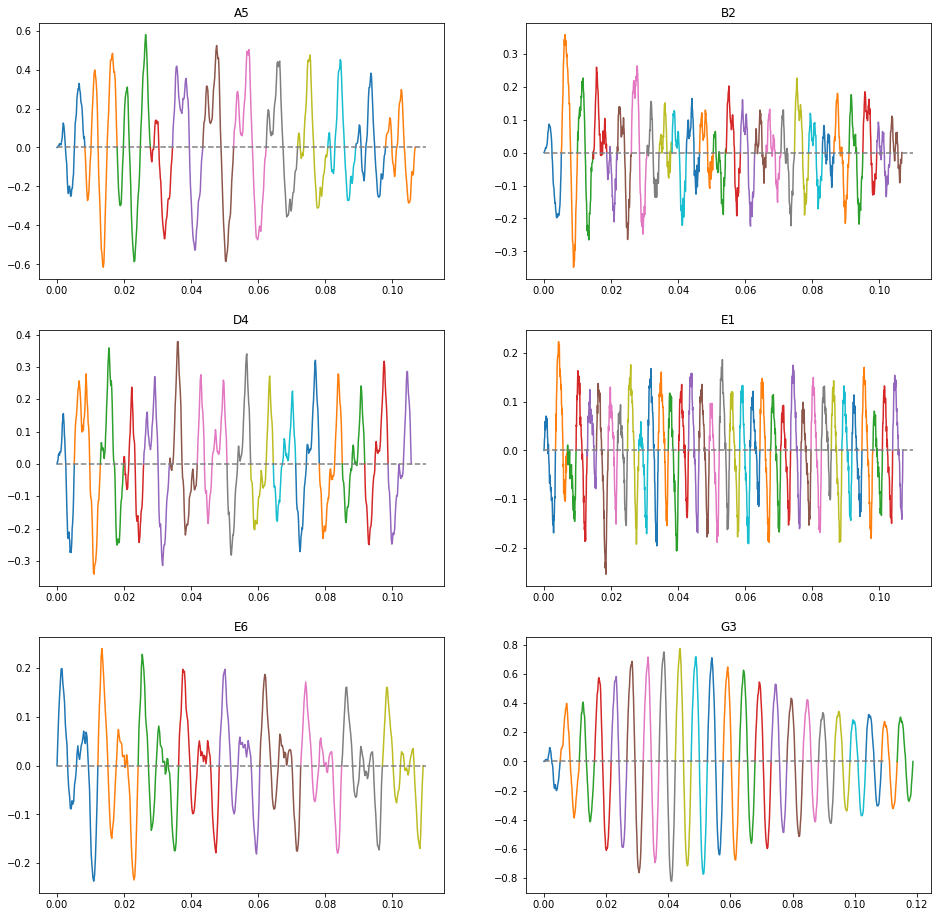

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

for idi, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    s = all_sounds[idi] 
    fund = du.note_freq(list(wood_sounds.keys())[idi]) 
    max_time=0.2

    # Create a spline interpolation of the signal
    spl = InterpolatedUnivariateSpline(s.signal.time(), s.signal.signal)
    # Fin the roots (zero crossings)
    spl_roots = spl.roots()
    # Find the first meaningfull zero crossing from the onset
    onset_thresh = 0.05
    onset_idx = np.where(s.signal.signal>onset_thresh)[0][0] # Where the signal first cross 0.05
    t = spl_roots[spl_roots<s.signal.time()[onset_idx]][-1]
    m_period = 1/fund
    period_cross = [t]
    # Find all the period spaced zero crossings
    while t < max_time:
        idx = np.argmin(np.abs(spl_roots - (t+m_period)))
        t = spl_roots[idx]
        period_cross.append(t)

    for i, ci in enumerate(period_cross[:-1]):
        time = np.linspace(ci, period_cross[i+1])
        sig = spl(time)
        time -= period_cross[0]
        #sig = s.signal.signal[np.logical_and(ci<=s.signal.time(), s.signal.time()<=period_cross[i+1])]
        #t = s.signal.time()[np.logical_and(ci<=s.signal.time(), s.signal.time()<=period_cross[i+1])]
        #t -= period_cross[0]
        plt.plot(time, sig)
    plt.plot([0, 0.11], [0, 0], color='0.5', linestyle='--')

    plt.title(list(wood_sounds.keys())[idi])

### 2.3 Period decomposition for each string of a classical guitar

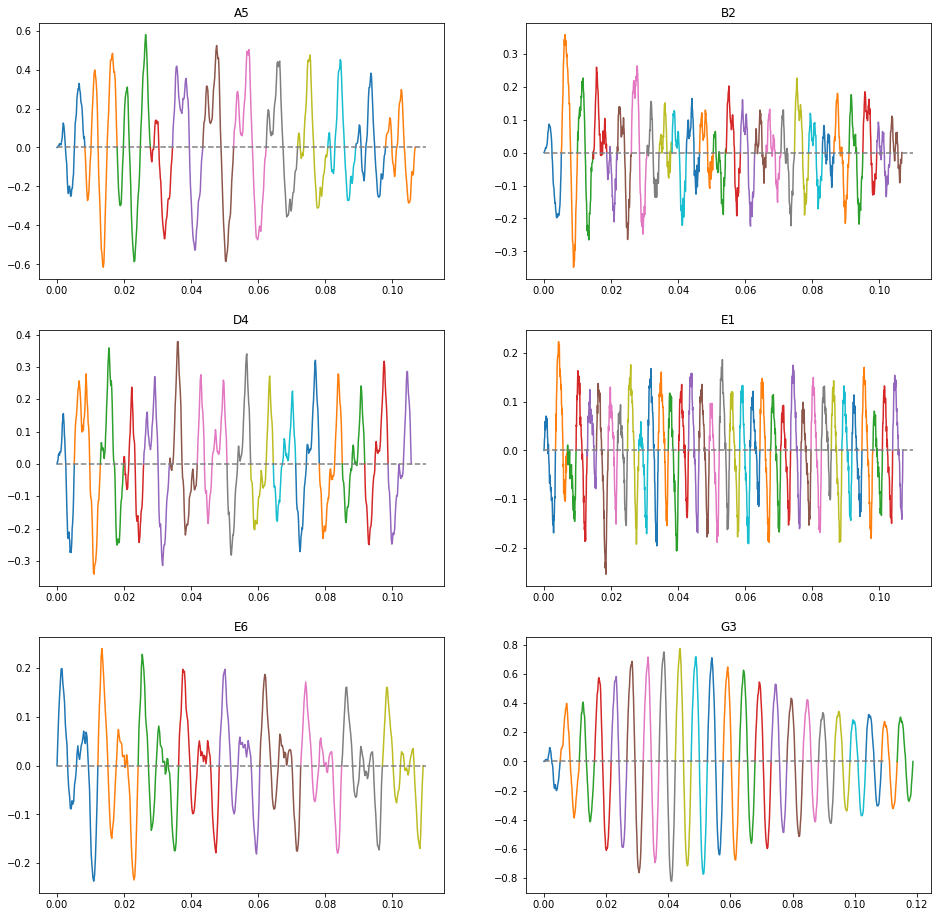

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

for idi, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    s = all_sounds[idi] 
    fund = du.note_freq(list(nylon_sounds.keys())[idi]) 
    max_time=0.2

    # Create a spline interpolation of the signal
    spl = InterpolatedUnivariateSpline(s.signal.time(), s.signal.signal)
    # Fin the roots (zero crossings)
    spl_roots = spl.roots()
    # Find the first meaningfull zero crossing from the onset
    onset_thresh = 0.05
    onset_idx = np.where(s.signal.signal>onset_thresh)[0][0] # Where the signal first cross 0.05
    t = spl_roots[spl_roots<s.signal.time()[onset_idx]][-1]
    m_period = 1/fund
    period_cross = [t]
    # Find all the period spaced zero crossings
    while t < max_time:
        idx = np.argmin(np.abs(spl_roots - (t+m_period)))
        t = spl_roots[idx]
        period_cross.append(t)

    for i, ci in enumerate(period_cross[:-1]):
        time = np.linspace(ci, period_cross[i+1])
        sig = spl(time)
        time -= period_cross[0]
        plt.plot(time, sig)
    plt.plot([0, 0.11], [0, 0], color='0.5', linestyle='--')

    plt.title(list(wood_sounds.keys())[idi])

**Fair performance**

### 2.3 Signal period data visualization

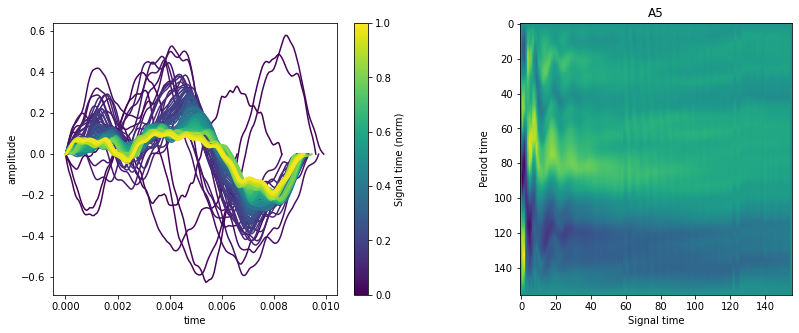

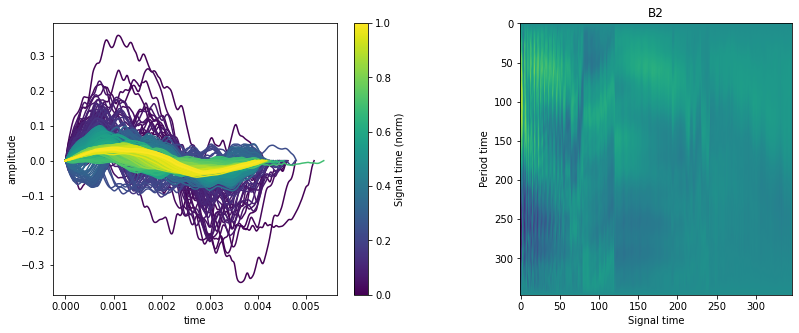

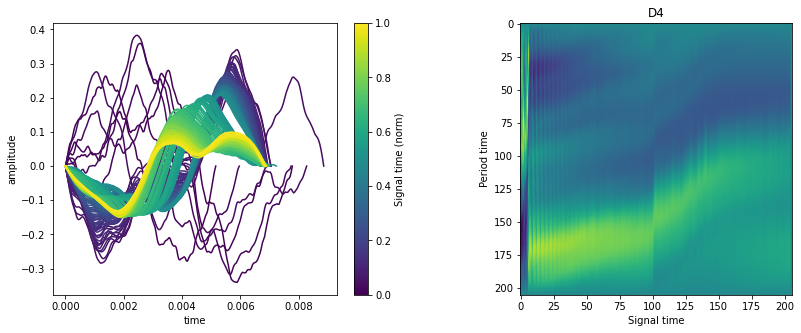

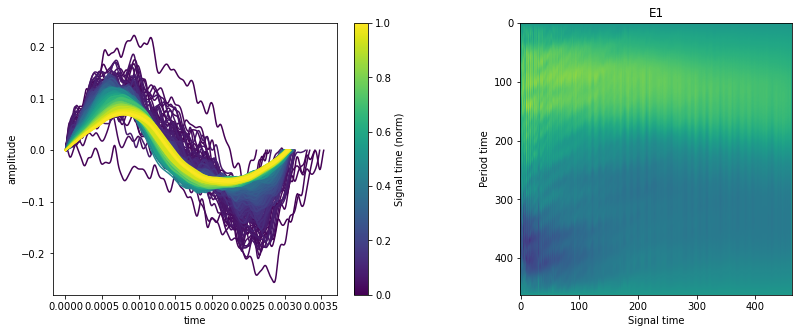

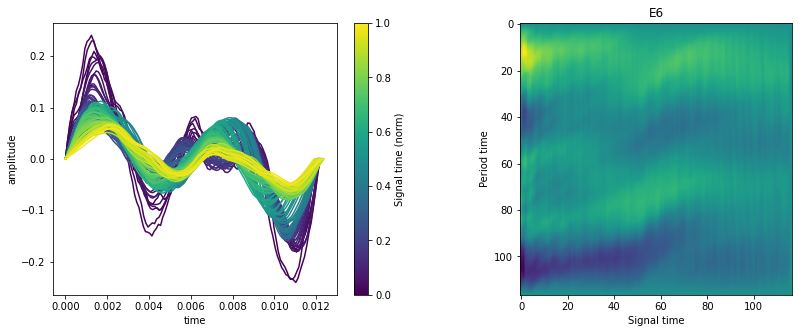

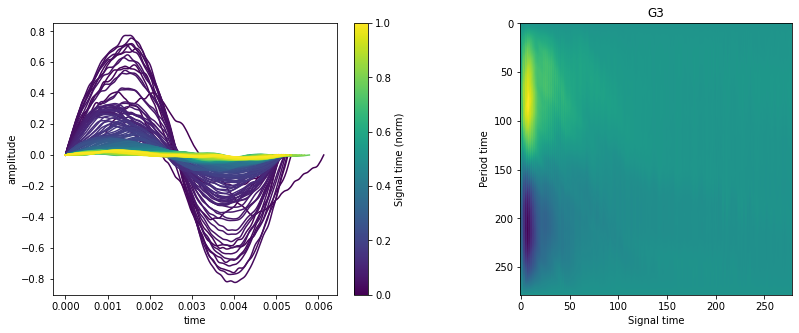

In [11]:
for idi in range(6):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    s = all_sounds[idi] 
    fund = du.note_freq(list(wood_sounds.keys())[idi]) 
    max_time=1.5

    # Create a spline interpolation of the signal
    spl = InterpolatedUnivariateSpline(s.signal.time(), s.signal.signal)
    # Fin the roots (zero crossings)
    spl_roots = spl.roots()
    # Find the first meaningfull zero crossing from the onset
    onset_thresh = 0.05
    onset_idx = np.where(s.signal.signal>onset_thresh)[0][0] # Where the signal first cross 0.05
    t = spl_roots[spl_roots<s.signal.time()[onset_idx]][-1]
    m_period = 1/fund
    period_cross = [t]
    # Find all the period spaced zero crossings
    while t < max_time:
        idx = np.argmin(np.abs(spl_roots - (t+m_period)))
        t = spl_roots[idx]
        period_cross.append(t)
        
    my_map = plt.colormaps['viridis']
    sig_img = np.zeros((len(period_cross), len(period_cross)))
    plt.sca(axs[0])
    for i, ci in enumerate(period_cross[:-1]):
        time = np.linspace(ci, period_cross[i+1], len(period_cross))
        sig = spl(time)
        sig_img[:, i] = sig
        time -= time[0]
        #sig = s.signal.signal[np.logical_and(ci<=s.signal.time(), s.signal.time()<=period_cross[i+1])]
        #t = s.signal.time()[np.logical_and(ci<=s.signal.time(), s.signal.time()<=period_cross[i+1])]
        #t -= period_cross[0]
        color = my_map(i/len(period_cross))
        plt.plot(time, sig, color=color)
    # Create a color map from the plot lines
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.colormaps['viridis'], norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Signal time (norm)')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('amplitude')
    plt.sca(axs[1])
    plt.imshow(sig_img)
    ax = axs[1]
    ax.set_ylabel('Period time')
    ax.set_xlabel('Signal time')
    plt.title(list(wood_sounds.keys())[idi])
    

### 2.4 Fourrier transform of the signal sub periods

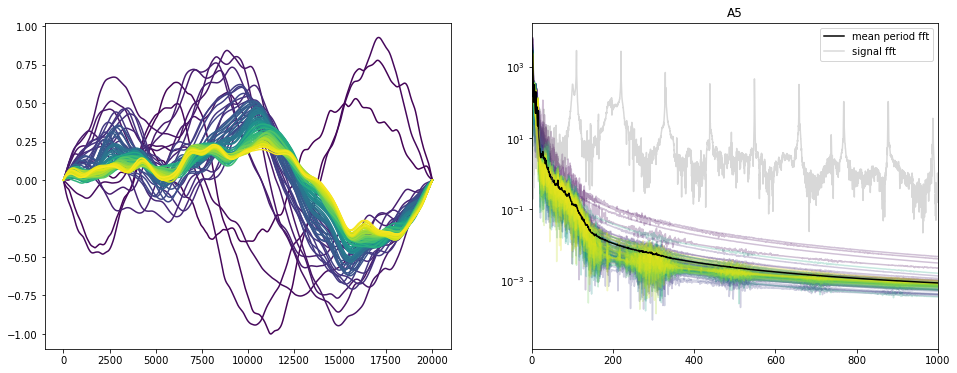

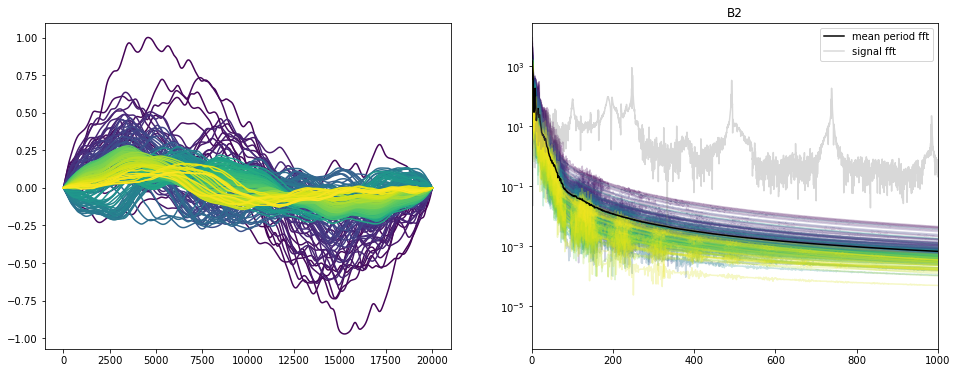

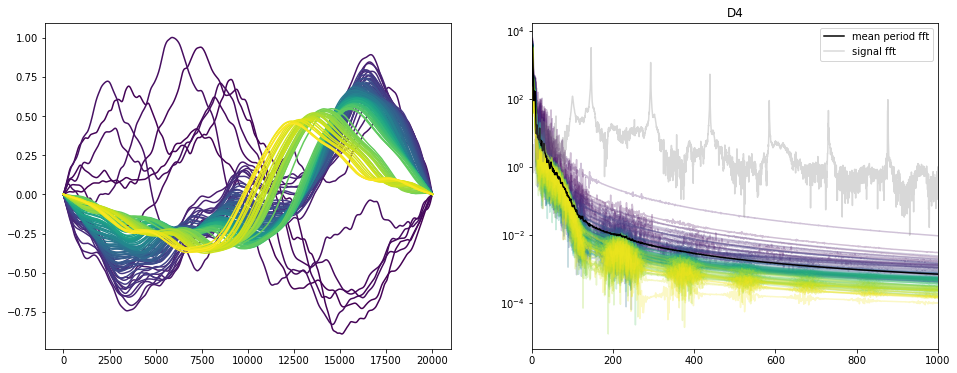

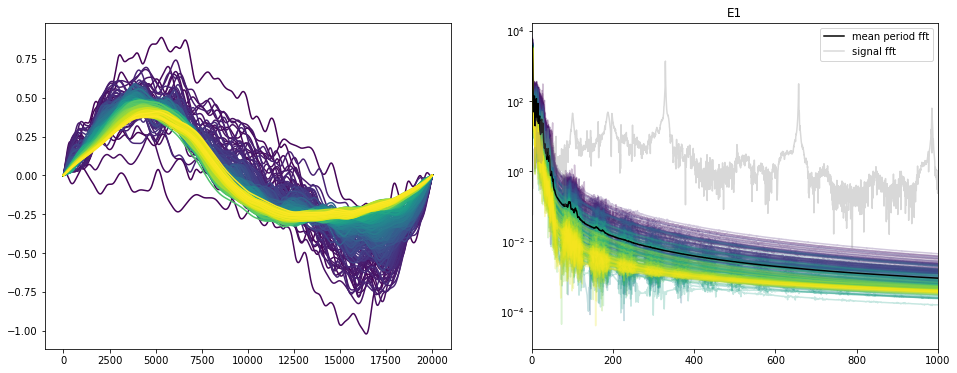

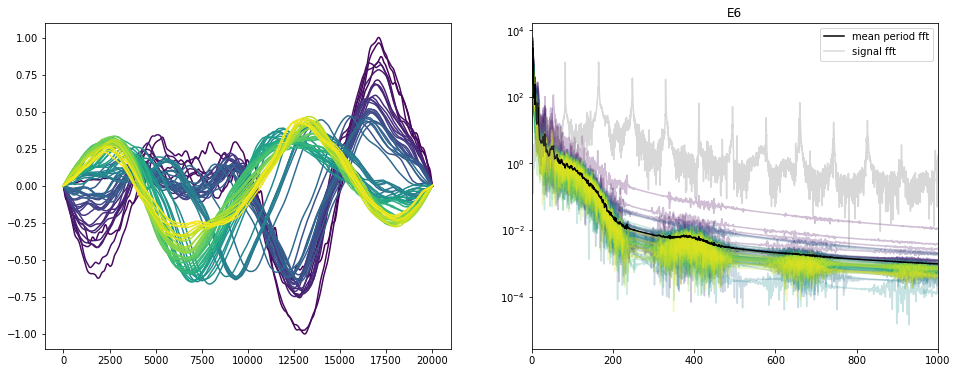

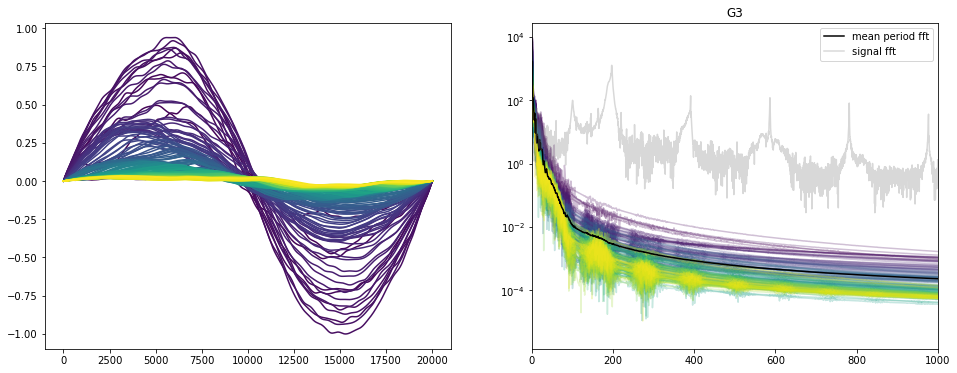

In [12]:
mean_ffts = []
mean_ft_fq = []

for idi in range(6):
    sound = all_sounds[idi]
    fund = du.note_freq(list(wood_sounds.keys())[idi])
    subsig_size=20000
    period_times, period_sigs = period_decomp(sound, fund, subsig_size=subsig_size)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plt.sca(ax[0])
    mymap = plt.colormaps['viridis']
    for st, si, i in zip(period_times, period_sigs, np.arange(len(period_times))):
        plt.plot(si, color=mymap(i/len(period_sigs)))

    plt.sca(ax[1])
    ffts = []
    cross = period_crossings(sound, fund)
    for i, si in enumerate(period_sigs):
        si_fft = np.fft.fft(si)
        si_fft = np.abs(si_fft)
        fft_freq = np.fft.fftfreq(len(si_fft), 1/len(si))
        si_fft = si_fft[:(si_fft.shape[0]//2)]
        fft_freq = fft_freq[:len(si_fft)]
        ffts.append(si_fft)
        plt.plot(fft_freq, si_fft,  color=mymap(i/len(period_sigs)), alpha=0.25)

    mean_ffts.append(np.mean(ffts, axis=0))
    mean_ft_fq.append(fft_freq)
    
    plt.plot(fft_freq, np.mean(ffts, axis=0), color='k', label='mean period fft')
    ft = du.real_fft(sound.signal)
    plt.plot(sound.signal.fft_frequencies(), ft, color='0.5', alpha=0.3, label='signal fft')
    ax[1].set_xlim(0, 1000)
    ax[1].set_yscale('log')
    ax[1].legend()
    ax[1].set_title(list(wood_sounds.keys())[idi])

### 2.5 Influence of signal fundamental on mean time FFT

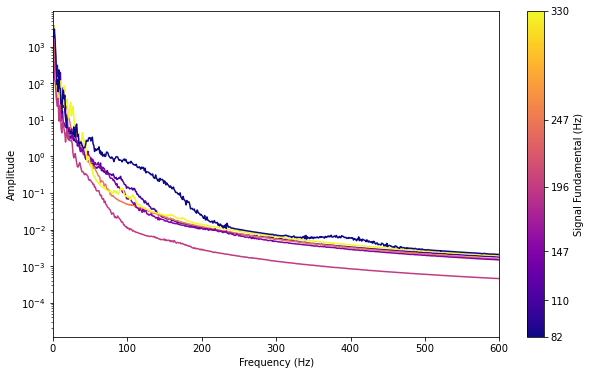

In [13]:
notes = np.array([du.note_freq(note) for note in wood_sounds])
notes_nm = notes - np.min(notes)
notes_nm /= np.max(notes_nm)
mymap = plt.colormaps['plasma']
for note, fq, ft in zip(notes_nm, mean_ft_fq, mean_ffts):
    plt.plot(fq, ft, color=mymap(note))
    
ax = plt.gca()
ax.set_yscale('log')
ax.set_xlim(0, 600)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
norm = mpl.colors.Normalize(vmin=np.min(notes), vmax=np.max(notes))
sm = plt.cm.ScalarMappable(cmap=mymap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=notes)
cbar.set_label('Signal Fundamental (Hz)')
du.bigfig()

- No clear trend in the impact of the fundamental on FFT shape

## 3. Sound generation for signal period data

### 3.1 Creating the An(t, f) interpolator

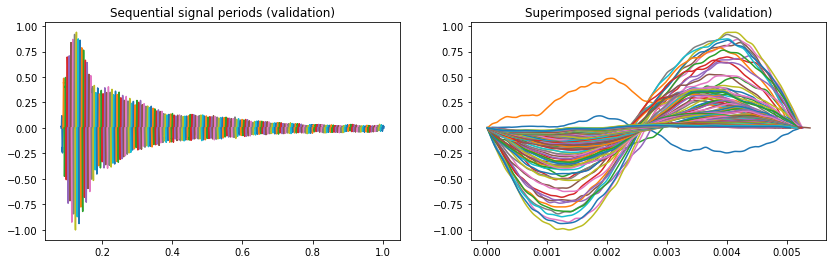

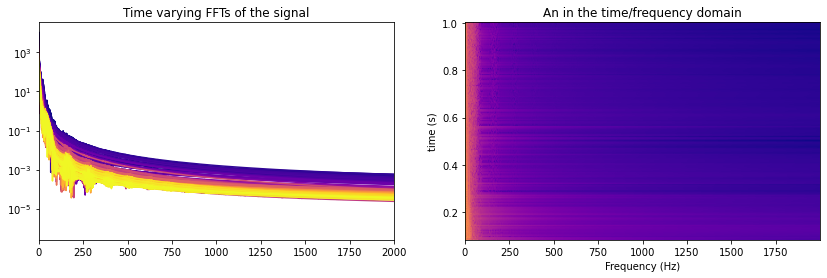

In [14]:
# get a test sound
idi = 0
si = all_sounds[idi]
fund = du.note_freq(list(wood_sounds.keys())[idi])

# divide into periods
period_times, period_sigs = period_decomp(sound, fund*2, subsig_size=si.signal.sr)

# Graphic validation
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
for pt, ps in zip(period_times, period_sigs):
    plt.sca(axs[0])
    plt.plot(pt, ps)
    plt.sca(axs[1])
    plt.plot(pt-pt[0], ps)
axs[0].set_title('Sequential signal periods (validation)')
axs[1].set_title('Superimposed signal periods (validation)')
    
# Compute the periods FFT and freq
period_ffts = []
period_freq = 0
for psig in period_sigs:
    psi_fft = np.fft.fft(psig)
    psi_fft = np.abs(psi_fft)
    fft_freq = np.fft.fftfreq(len(psi_fft), 1/len(psig))
    psi_fft = psi_fft[:(psi_fft.shape[0]//2)]
    fft_freq = fft_freq[:len(psi_fft)]
    period_ffts.append(psi_fft)
period_freq = fft_freq

# Graphic validation
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
plt.sca(axs[0])
ax = axs[0]
for i, ft in enumerate(period_ffts):
    plt.plot(period_freq, ft, color=mymap(i/len(period_ffts)))
ax.set_xlim(0, 2000)
ax.set_yscale('log')
axs[0].set_title('Time varying FFTs of the signal')

# Create interpolators for the An values
# Get the center time of each period
start_times = np.array([pt[0] for pt in period_times])
stop_times = np.array([pt[-1] for pt in period_times])
center_times = (start_times + stop_times)/2
itrp2d_fqti = interp2d(fft_freq, center_times, period_ffts)

plt.sca(axs[1])
fplot = fft_freq[fft_freq<2000]
tplot = np.linspace(center_times[0], center_times[-1], len(fplot))
An_data = itrp2d_fqti(fplot, tplot)
plt.pcolormesh(fplot, tplot, np.log(An_data), cmap='plasma')
axs[1].set_ylabel('time (s)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_title('An in the time/frequency domain')

plt.show()

- The interpolator is noisy in the time domain

### 3.2 An interpolator visualization in the time domain

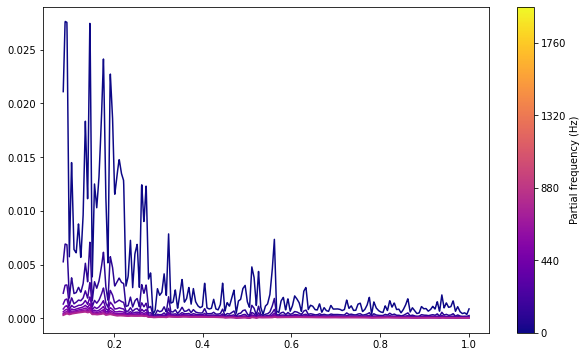

In [15]:
# Compute the time data from the interpolator at all the partials
partials = np.array([fund*2*n for n in range(10)])
An_time = itrp2d_fqti(partials, tplot)
for i, An_ti in enumerate(An_time.T[1:]):
    plt.plot(tplot, An_ti, color=mymap(i/20))
    
norm = mpl.colors.Normalize(vmin=np.min(partials), vmax=np.max(partials))
sm = plt.cm.ScalarMappable(cmap=mymap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=partials[::2])
cbar.set_label('Partial frequency (Hz)')
#plt.gca().set_yscale('log')
du.bigfig()

### 3.3 Testing sound generation from period data

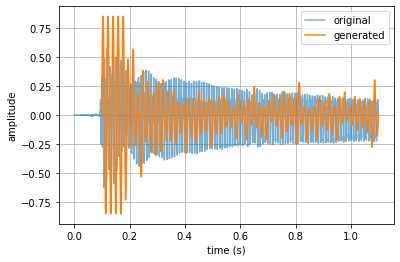

In [16]:
idi = 0
si = all_sounds[idi]
fund = du.note_freq(list(wood_sounds.keys())[idi])

# Compute the periods
period_times, period_sigs = period_decomp(sound, fund*2, subsig_size=si.signal.sr)
# Get the center time of each period
start_times = np.array([pt[0] for pt in period_times])
stop_times = np.array([pt[-1] for pt in period_times])
center_times = (start_times + stop_times)/2

def fft_time_amplitude(freq, period_ffts, period_freq):
    idx = np.argmin(np.abs(period_freq - freq))
    return np.array(period_ffts)[:, idx]

# Compute the periods FFT and freq
period_ffts = []
period_freq = 0
for psig in period_sigs:
    psi_fft = np.fft.fft(psig)
    psi_fft = np.abs(psi_fft)
    fft_freq = np.fft.fftfreq(len(psi_fft), 1/len(psig))
    psi_fft = psi_fft[:(psi_fft.shape[0]//2)]
    fft_freq = fft_freq[:len(psi_fft)]
    period_ffts.append(psi_fft)
period_freq = fft_freq
    

fn = fund/2

new_sig = 0
t = np.linspace(0, 1, si.signal.sr)
interpolators_An = []

while fn < 2000:
    new_sig += itrp2d_fqti(fn, t).reshape(-1) * np.sin(fn * t * 2 * np.pi)
    fn *= 2
    
si.signal.trim_time(1.1).plot.signal(label='original')
plt.plot(t+0.1, new_sig, label='generated')
plt.legend()
plt.show()

du.arr2sig(new_sig).normalize().listen()

- Higher partials are not well reprensented
- Time domain behavior is bad
- Sounds bad
- 2D An interpolator was maybe a good idea

# FFT Base signal sound generation tuning

## 1. Visualization of the An 2D interpolator for a single signal (Wood A string)

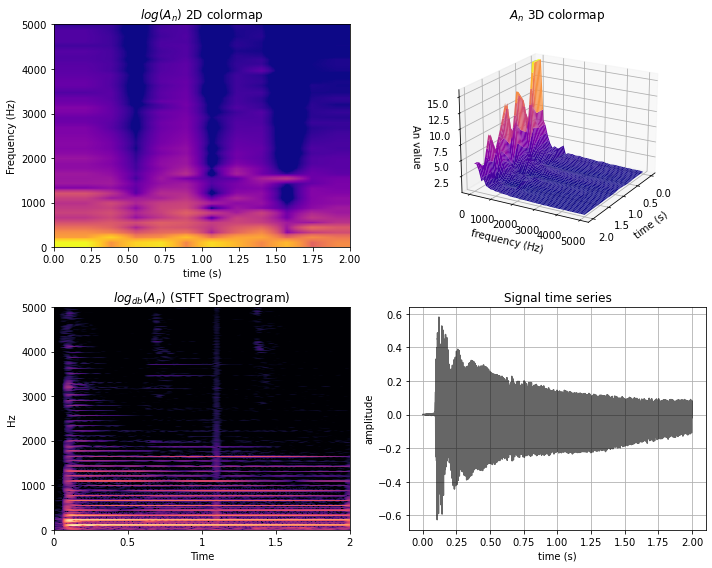

In [17]:
# Choose a sound
s = all_sounds[0]
maxtime = 2

# Sound division in intervals
time_intervals = np.linspace(0.13, maxtime, maxtime*(du.get_arrgen_interval(s)+1))
sub_sigs = []
for i, _ in enumerate(time_intervals[:-1]):
    # create a signal from subset
    idx1 = du.time_index(s.signal, time_intervals[i])
    idx2 = du.time_index(s.signal, time_intervals[i+1])
    new_sig = guitarsounds.Signal(s.signal.signal[idx1:idx2], s.signal.sr, s.SP)
    sub_sigs.append(new_sig)
    
# Allow generating the complete FFT
s.signal.SP.change('fft_range', 12000)
peaks = s.signal.peaks()
peak_freqs = s.signal.fft_frequencies()[peaks]
center_times = [np.mean([time_intervals[i], time_intervals[i+1]]) for i in range(len(time_intervals)-1)]

# Create the An data array
# for each sub signal
An_data = []
for sig in sub_sigs:
    An_sig = []
    for pf in peak_freqs:
        fidx = du.frequency_index(sig, pf)
        pkidx = np.argmax(sig.fft()[fidx-10:fidx+10]) + fidx
        An_sig.append(du.real_fft(sig)[pkidx])
    An_data.append(An_sig)
    
itrp_fft_recon = interp2d(center_times, peak_freqs, np.array(An_data).T)

time = np.linspace(0, maxtime, 500)
freq = np.linspace(0, 5000, 500)
An_itrp = itrp_fft_recon(time, freq)

An_3d = np.log(An_itrp)
if np.mean(An_3d)<0:
    An_3d[An_3d<np.mean(An_3d)*2] = np.mean(An_3d)*2
else:
    An_3d[An_3d<np.mean(An_3d)/2] = np.mean(An_3d)/2
    
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(2, 2, 1)
ax.pcolormesh(time, freq, An_3d, cmap='plasma')
ax.set_ylim(0, 5000)
ax.set_xlabel('time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(r'$log(A_n)$ 2D colormap')

ax = fig.add_subplot(2, 2, 2, projection='3d')
T, F = np.meshgrid(time, freq)
surf = ax.plot_surface(T, F, np.exp(An_3d), cmap='plasma', antialiased=True)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_zlabel('An value')
ax.set_title(r'$A_n$ 3D colormap')
ax.view_init(20, 30)

ax = fig.add_subplot(2, 2, 4)
plt.sca(ax)
ax.set_title('Signal time series')
s.signal.trim_time(2).plot.signal(color='k')

ax = fig.add_subplot(2, 2, 3)
y, sr = s.signal.trim_time(2).signal, s.signal.sr
D = librosa.stft(y, hop_length=32)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.sca(ax)
img = librosa.display.specshow(S_db, hop_length=32, x_axis='time', y_axis='linear', ax=ax, sr=sr)
ax.set_ylim(0, 5000)
ax.set_title(r'$log_{db}(A_n)$ (STFT Spectrogram)')


plt.tight_layout()

- The FFT peaks signal reconstructions is similar to the signal spectrogram

## 2. Mean signal spectrogram for sound generation

### 2.1 Mean spectrogram visualization

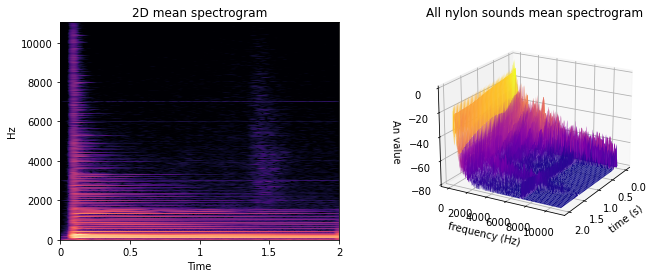

In [18]:
all_specs = []
for ky in wood_sounds:
    si = nylon_sounds[ky]
    y, sr = si.signal.trim_time(2).signal, s.signal.sr
    D = librosa.stft(y, hop_length=32)  # STFT of y
    all_specs.append(np.abs(D))
all_specs = np.array(all_specs)

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(1, 2, 1)
S_db = librosa.amplitude_to_db(np.mean(all_specs, axis=0), ref=np.max)
img = librosa.display.specshow(S_db, hop_length=32, x_axis='time', y_axis='linear', ax=ax)
ax.set_title('2D mean spectrogram')

ax = fig.add_subplot(1, 2, 2, projection='3d')
T, F = np.meshgrid(librosa.frames_to_time(np.arange(S_db.shape[1]), hop_length=32), 
                   librosa.fft_frequencies(sr=sr))
surf = ax.plot_surface(T, F, S_db, cmap='plasma', antialiased=True)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_zlabel('An value')
ax.set_title(r'All nylon sounds mean spectrogram')
ax.view_init(20, 30)

### 2.2 Construction of a 2D An interpolator

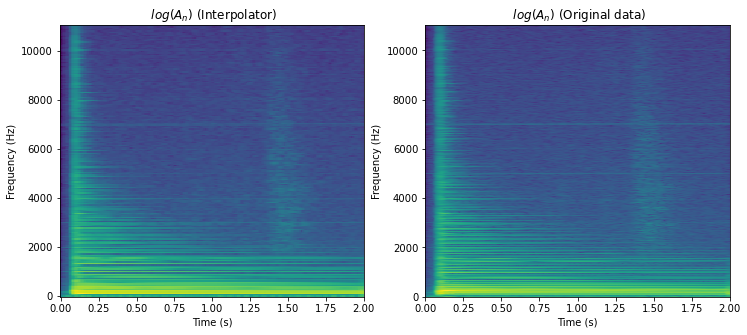

In [19]:
# Create a 2D interpolator from the data
SC_data = du.mean_spec(nylon_sounds.values())
frq = librosa.fft_frequencies(sr=sr)
tim = librosa.frames_to_time(np.arange(SC_data.shape[1]), hop_length=32)
An_itrp = interp2d(tim, frq, SC_data)

# Graphic validation
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
ax.set_title(r' $log(A_n)$ (Interpolator)')
du.tf_decor(ax)
titr = np.linspace(tim[0], tim[-1], 200)
fitr = np.linspace(frq[0], frq[-1], 200)
ax.pcolormesh(titr, fitr, np.log(An_itrp(titr, fitr)))
ax = axs[1]
ax.set_title(f' $log(A_n)$ (Original data)')
du.tf_decor(ax)
ax.pcolormesh(tim, frq, np.log(SC_data))

plt.show()

### 2.3 Sound generation from spectrogram data

In [20]:
nylon_spec = du.mean_spec(nylon_sounds.values())
frq = librosa.fft_frequencies(sr=sr)
tim = librosa.frames_to_time(np.arange(nylon_spec.shape[1]), hop_length=32)

An_itrp = interp2d(tim, frq, nylon_spec)

# Use theoretical partial data
fund = 110  # Hz
# Time at sample rate intervals
time=np.linspace(tim[0], tim[-1], 22050*2)
sigarr=0

while fund < 10000:
    tmp = An_itrp(time, fund) * np.sin(fund * time * 2 * np.pi)
    sigarr += tmp
    fund += 110

sigarr *= 0.95 / np.max(np.abs(sigarr))
    
# Apply onset envelop
env = du.get_expenv(-1)
# Apply it to time = 0.0 - 0.1 s
t_idx = np.arange(time.shape[0])[time < 0.1][-1]
sigarr[:t_idx] = env(t[:t_idx]) * sigarr[:t_idx]
# Fade out the last 20 samples
sigarr[-20:] = sigarr[-20:] * np.linspace(1, 0.1, 20)

print('110 Hz Nylon sound')
nylon_sounds['A5'].signal.normalize().listen()
print('Generated')
du.listen_sig_array(sigarr)

110 Hz Nylon sound


Generated


### 2.4 Analysis of the generated sound

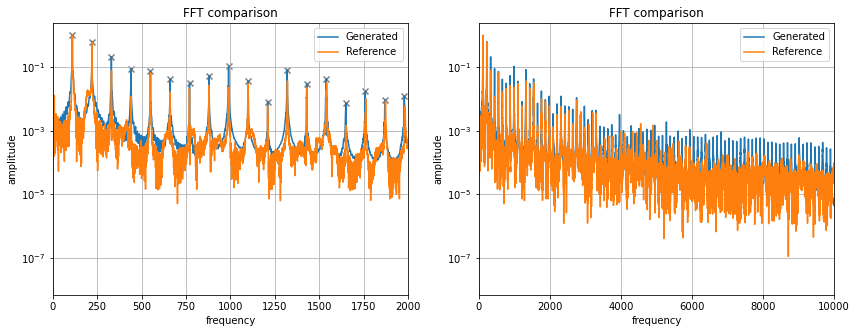

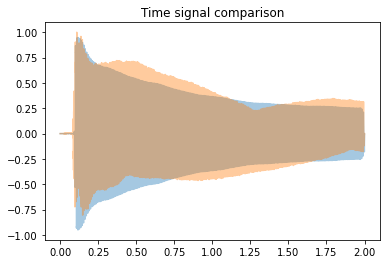

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sig =  du.arr2sig(sigarr)

ax = axs[0]
plt.sca(ax)
ax.plot(sig.fft_frequencies(), sig.fft(), label='Generated')
nylon_sounds['A5'].signal.plot.fft(label='Reference')
ax.scatter(sig.fft_frequencies()[sig.peaks()], sig.fft()[sig.peaks()], marker='x', color='0.5')
ax.set_xlim(0, 2000)
ax.legend()
ax.set_title('FFT comparison')

ax = axs[1]
plt.sca(ax)
ax.plot(sig.fft_frequencies(), sig.fft(), label='Generated')
nylon_sounds['A5'].signal.plot.fft(label='Reference')
ax.set_xlim(0, 10000)
ax.legend()
ax.set_title('FFT comparison')

fig, ax = plt.subplots()
plt.sca(ax)
plt.plot(time, sigarr, alpha=0.4)
ref_sig = nylon_sounds['A5'].signal.trim_time(2)
plt.plot(ref_sig.time(), ref_sig.normalize().signal, alpha=0.4)
ax.set_title('Time signal comparison')

plt.show()

- Good fit of the low frequencies
- High frequencies are too powerfull
- The time envelop is good

### 2.5 Smoothing the An interpolator data

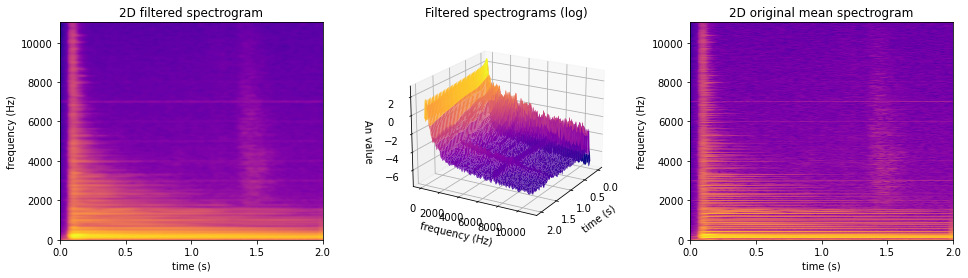

In [22]:
from scipy.ndimage import convolve

# Visualize the kernels
kernel = np.array([[1, 1, 1,],
                   [1, 1, 1,],
                   [1, 1, 1,],])


kernel = kernel/np.sum(kernel)

An_mean = du.mean_spec(nylon_sounds.values())
An_filtr = An_mean
for i in range(20):
    An_filtr = convolve(An_filtr, kernel)

frq = librosa.fft_frequencies(sr=sr)
tim = librosa.frames_to_time(np.arange(An_mean.shape[1]), hop_length=32)


fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
ax.pcolormesh(tim, frq, np.log(An_filtr), cmap='plasma')
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('2D filtered spectrogram')

ax = fig.add_subplot(1, 3, 2, projection='3d')
T, F = np.meshgrid(tim, frq)
surf = ax.plot_surface(T, F, np.log(An_filtr), cmap='plasma', antialiased=True)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_zlabel('An value')
ax.set_title(r'Filtered spectrograms (log)')
ax.view_init(20, 30)

ax = fig.add_subplot(1, 3, 3)
ax.pcolormesh(tim, frq, np.log(An_mean), cmap='plasma')
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('2D original mean spectrogram')

plt.show()

### 2.6 Sound generation with the filtered spectrogram

In [23]:
nylon_spec = du.mean_spec(nylon_sounds.values())
time = spec_time(nylon_spec)
freq = spec_freq()

for i in range(10, 41, 10):
    itrp = An_interpolator(time, freq, nylon_spec, filtr=i)
    sig_arr = sound_arr_from_itrp(itrp, 110)
    print(f'Filter passes {i}')
    du.listen_sig_array(sig_arr)
    

Filter passes 10


Filter passes 20


Filter passes 30


Filter passes 40


- Still not quite

### 2.7 Visualizing the differences with the original signal

Text(0.5, 1.0, 'Absolute difference')

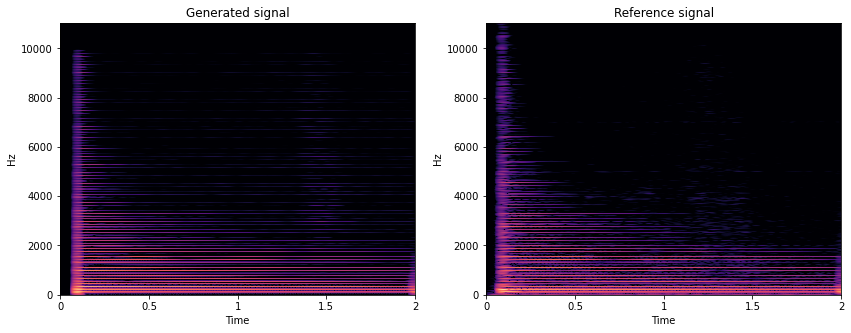

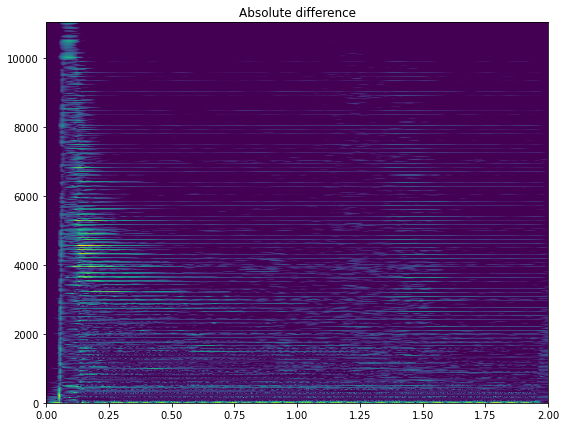

In [24]:
nylon_spec = du.mean_spec(nylon_sounds.values())
time = spec_time(nylon_spec)
freq = spec_freq()
itrp = An_interpolator(time, freq, nylon_spec)

sig_arr = sound_arr_from_itrp(itrp, 110)
sig = du.arr2sig(sig_arr)
sigr = nylon_sounds['A5']

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ax = axs[0]
y = sig.trim_time(2).signal
D = librosa.stft(y, hop_length=32)  # STFT of y
S_db_g = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.sca(ax)
img = librosa.display.specshow(S_db_g, hop_length=32, x_axis='time', y_axis='linear', ax=ax, sr=sr)
#ax.set_ylim(0, 5000)
ax.set_title('Generated signal')

ax = axs[1]
y = sigr.signal.trim_time(2).signal
D = librosa.stft(y, hop_length=32)  # STFT of y
S_db_r = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.sca(ax)
img = librosa.display.specshow(S_db_r, hop_length=32, x_axis='time', y_axis='linear', ax=ax, sr=sr)
#ax.set_ylim(0, 5000)
ax.set_title('Reference signal')

plt.figure(figsize=(9, 7))
S1 = -S_db_r/np.max(-S_db_r)
S2 = -S_db_g/np.max(-S_db_g)
diff = np.abs(S1 - S2)
diff = diff/np.max(diff)
plt.pcolormesh(spec_time(D), spec_freq(), diff)
plt.gca().set_title('Absolute difference')
